In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pywt
from pywt import wavedec

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams.update({'font.size': 12})

In [2]:
df = pd.read_csv('raw_data.csv', index_col = ['moment'], parse_dates = ['moment'])

In [3]:
vibr_ax = 'SM_Exgauster\[0:8]'
vibr_ax8 = 'SM_Exgauster\[0:11]'

<Axes: xlabel='moment'>

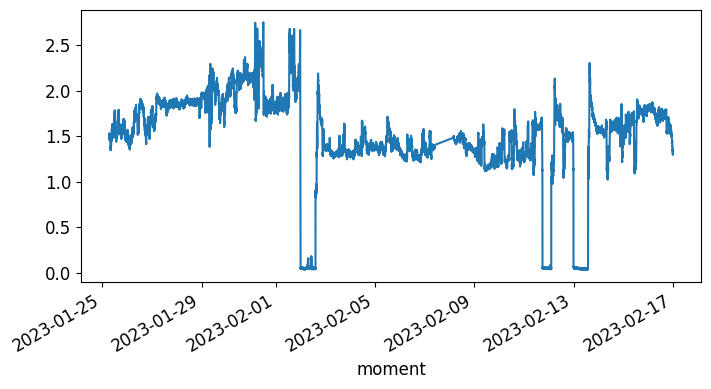

In [4]:
df[vibr_ax].plot()

# Применим разложение хаара к вибрации

Преобразования Фурье будет работать очень хорошо, когда частотный спектр стационарный. 
Чем нестационарнее сигнал, тем хуже будут результаты. Это проблема, так как большинство сигналов, которые мы видим в реальной жизни, нестационарны по своей природе.
У нас сигнал не стационарен! Поэтому мы и должны смотреть что-то сложнее Фурье

In [5]:
cA, cD = wavedec(df[vibr_ax].values, 'haar', mode='zero', level=1)

На выходе 2 вектора: 

Коэффициенты аппроксимации (cA) представляют выход фильтра нижних частот (фильтра усреднения) DWT. Коэффициенты детализации (cD) представляют выход фильтра высоких частот (разностного фильтра) DWT.

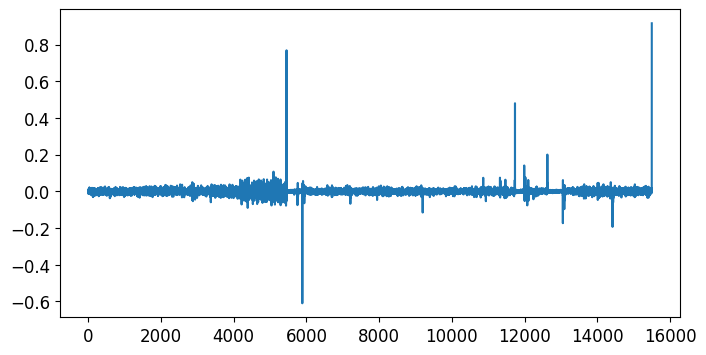

In [6]:
plt.plot(cD)

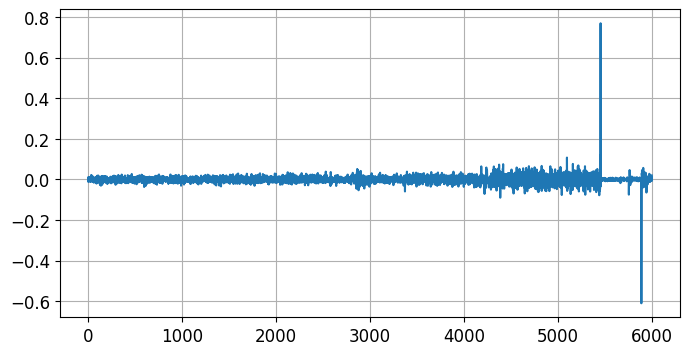

In [7]:
plt.grid()
plt.plot(cD[0:6000])

## Попробуем построить модель

In [8]:
from sklearn.linear_model import LinearRegression, Ridge

In [9]:
# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

# mean_r = moving_average(np.abs(cD), 20)

# x_train = mean_r[0:5000]

In [10]:
# проходим скользящим окном и выбираем максимальные значения cD

max_r = np.lib.stride_tricks.sliding_window_view(np.abs(cD), 20).max(axis=1)

# для построения выбираем 0:5000 значений cD
# на 5000:6000 будем как бы "тестировать"
x_train = max_r[0:5000]

In [11]:
x_train = x_train[~np.isnan(x_train)]

In [12]:
time = np.arange(0, len(x_train), 1)
model = Ridge() # линейное уравнение, но с коэффициентом регуляризации
model.fit(time.reshape(-1, 1), x_train)

Ridge()

In [13]:
x_for_plot = np.arange(0, 6000)
predict = model.predict(x_for_plot.reshape(-1, 1))

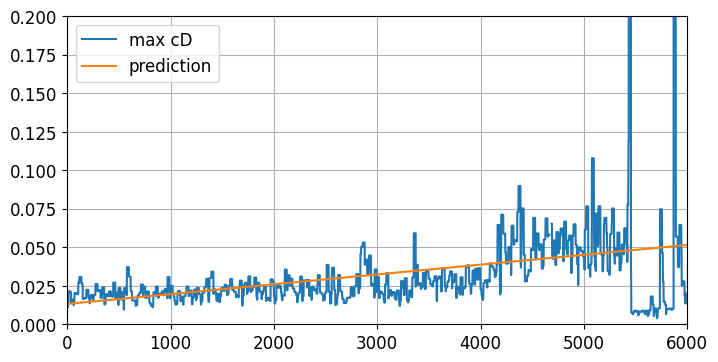

In [14]:
plt.grid()
plt.plot(max_r, label='max cD')
plt.plot(x_for_plot, predict, label='prediction')
plt.ylim([0, 0.2])
plt.xlim([0, 6000])

plt.legend()

Выбрать граничные значения, например:
если предсказанное значение max cD по вибрации привысит 0.05, то в этот момет будет поломка.



На будущее:
Можно попробовать решать как задачу кластеризации -- то есть может состояние экзгаустера разделиться на 3 группы, которые можно охарактеризовать как 
- нормальное, 
- предаварийное (имеются нарушение), 
- авария.

Тогда, просто диагностируя состояния "предаварийное" уже сообщать оператору о возможных поломках в будущем. 